In [20]:
import itertools
import os
from glob import glob

import imageio
import numpy as np
import tensorflow as tf
from skimage.io import imsave
from tqdm.notebook import tqdm

from adain.image_utils import imshow, prepare_visualization_image, read_image

In [4]:
content_images = glob('assets/images/content/*')
style_images = glob('assets/images/style/*')
print('Found {} content and {} style images'.format(
    len(content_images), len(style_images)))

Found 11 content and 20 style images


In [5]:
saved_model = tf.saved_model.load('export')
inference_fn = saved_model.signatures['serving_default']

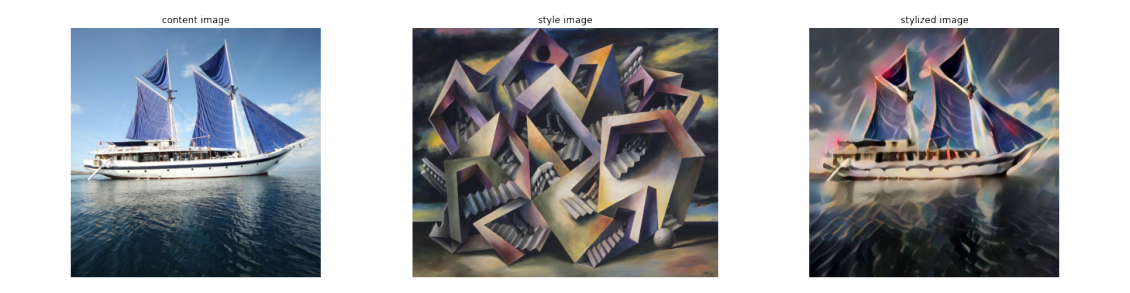

In [50]:
content_image = read_image(content_images[3])
style_image = read_image(style_images[16])

alpha = tf.constant(1.0)
resize = tf.constant(True)

serving_input = {
    'style_images': style_image,
    'content_images': content_image,
    'alpha': alpha,
    'resize': resize
}

stylized_image = inference_fn(**serving_input)['stylized_images'][0]
result = prepare_visualization_image(
    content_image[0], 
    style_image[0], 
    stylized_image, figsize=(20, 5))

imsave('assets/images/5.png', result)
imshow(result, figsize=(20, 10))

In [7]:
def animate_stylization(content_image, style_image, resize=True, num_steps=100):
    results = []
    resize = tf.constant(resize)
    for alpha in tqdm(np.linspace(0.0, 1.0, num=num_steps)):
        alpha = tf.constant(alpha, dtype=tf.float32)
        serving_input = {
            'style_images': style_image,
            'content_images': content_image,
            'alpha': alpha,
            'resize': resize
        }
        results += [inference_fn(**serving_input)['stylized_images'][0].numpy()]
    return results + results[::-1]

In [ ]:
content_style_pairs = [
    ('assets/images/content/avril.jpg', 'assets/images/style/impronte_d_artista.jpg'),
    ('assets/images/content/chicago.jpg', 'assets/images/style/asheville.jpg'),
    ('assets/images/content/cornell.jpg', 'assets/images/style/woman_with_hat_matisse.jpg'),
    ('assets/images/content/lenna.jpg', 'assets/images/style/en_campo_gris.jpg'),
    ('assets/images/content/newyork.jpg', 'assets/images/style/brushstrokes.jpg'),
    ('assets/images/content/sailboat.jpg', 'assets/images/style/sketch.png'),    
]
for content_image, style_image in tqdm(content_style_pairs):
    c_image = read_image(content_image)
    s_image = read_image(style_image)    
    results = animate_stylization(
        c_image,
        s_image,
        num_steps=50,
        resize=True)
    output_name = '{}_{}'.format(
        os.path.basename(content_image).split('.')[0],
        os.path.basename(style_image).split('.')[0])
    imageio.mimsave('assets/gifs/{}.gif'.format(output_name), results)    